In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from dnn_pytorch_func import Classifier, set_seed, plot_nn_progress
from util_model_evaluation import get_model_evaluation

### Loading dataset

In [2]:
df_train = pd.read_csv("data/original_train_data.csv")
df_test = pd.read_csv("data/original_test_data.csv")

X_train, y_train = df_train.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_train['is_duplicate']
X_test, y_test = df_test.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_test['is_duplicate']

df_train_with_fuzz = pd.read_csv("data/train_data_with_fuzz_features.csv")
df_test_with_fuzz = pd.read_csv("data/test_data_with_fuzz_features.csv")

X_train_with_fuzz, y_train_with_fuzz = df_train_with_fuzz.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_train_with_fuzz['is_duplicate']
X_test_with_fuzz, y_test_with_fuzz = df_test_with_fuzz.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_test_with_fuzz['is_duplicate']

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_nn = torch.tensor(X_train_with_fuzz.to_numpy(), dtype = torch.float32).to(device)
y_train_nn = torch.tensor(y_train_with_fuzz.to_numpy(), dtype = torch.float32).reshape(-1, 1).to(device)
X_test_nn = torch.tensor(X_test_with_fuzz.to_numpy(), dtype = torch.float32).to(device)

### Train neural network

In [4]:
set_seed(42)

# Assuming X_train is defined and has a .columns attribute
NUM_INPUTS = len(X_train_with_fuzz.columns)
nn_clf = Classifier(NUM_INPUTS).to(device)

loss_fn = nn.BCELoss()
opt_fn = optim.Adam(nn_clf.parameters(), lr = 0.001)

train_dataset = TensorDataset(X_train_nn, y_train_nn)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

losses, accuracies = nn_clf.train_model(train_loader, loss_fn, opt_fn, n_epochs = 5, device = device)
torch.save(nn_clf.state_dict(), 'models/dnn_model_weights.pth')

Completed Epoch 1/5, Average Loss: 0.5490
Completed Epoch 2/5, Average Loss: 0.5245
Completed Epoch 3/5, Average Loss: 0.5174
Completed Epoch 4/5, Average Loss: 0.5123
Completed Epoch 5/5, Average Loss: 0.5103


### Training performance over time 
5 epochs seems quite nice

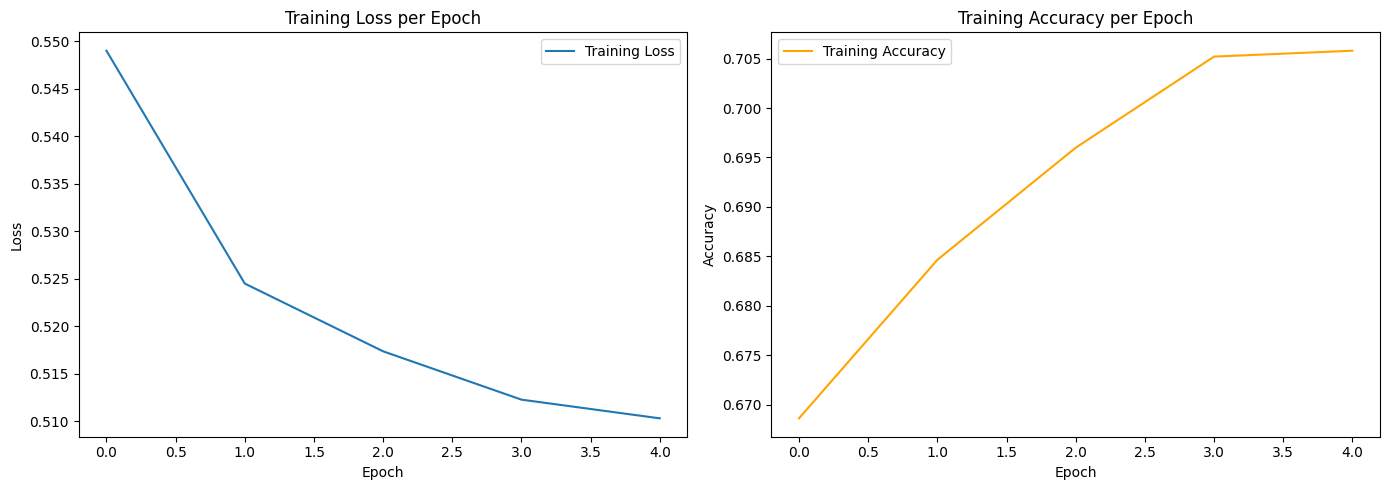

In [5]:
plot_nn_progress(losses, accuracies)

### Reloading model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_clf_loaded = Classifier(NUM_INPUTS)

# Option 1: Load weights then move model
nn_clf_loaded.load_state_dict(torch.load('models/dnn_model_weights.pth'))
nn_clf_loaded.to(device)

Classifier(
  (hidden1): Linear(in_features=8, out_features=8, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=8, out_features=32, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (act_output): Sigmoid()
)

### Model evaluation
Model was reasonably fitted as accuracy is approximately the same for train and test set.

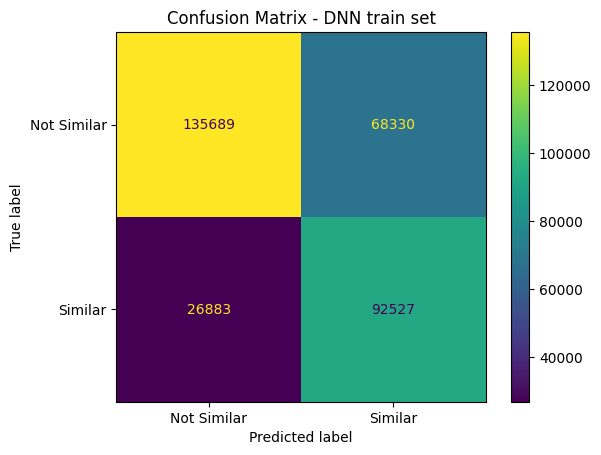

              precision    recall  f1-score   support

 Not Similar       0.83      0.67      0.74    204019
     Similar       0.58      0.77      0.66    119410

    accuracy                           0.71    323429
   macro avg       0.70      0.72      0.70    323429
weighted avg       0.74      0.71      0.71    323429

Accuracy: 0.706
Recall: 0.775
Precision: 0.575
F1-score: 0.66


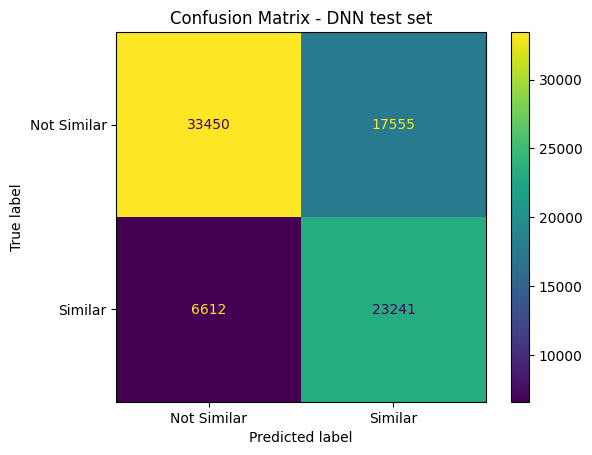

              precision    recall  f1-score   support

 Not Similar       0.83      0.66      0.73     51005
     Similar       0.57      0.78      0.66     29853

    accuracy                           0.70     80858
   macro avg       0.70      0.72      0.70     80858
weighted avg       0.74      0.70      0.71     80858

Accuracy: 0.701
Recall: 0.779
Precision: 0.57
F1-score: 0.658


{'accuracy': 0.701, 'recall': 0.779, 'precision': 0.57, 'f1': 0.658}

In [10]:
nn_clf_loaded.eval()

# Disable gradient calculation since we're only evaluating
with torch.no_grad():
    # Move to CPU and round predictions
    y_pred_tensor = nn_clf_loaded(X_test_nn)
    y_pred_train_tensor = nn_clf_loaded(X_train_nn)

# Convert to numpy array for sklearn metrics
y_pred_train = y_pred_train_tensor.detach().round().cpu().numpy()
y_pred = y_pred_tensor.detach().round().cpu().numpy()
labels = ["Not Similar", "Similar"]

get_model_evaluation(y_train, y_pred_train, labels, 'DNN train set')
get_model_evaluation(y_test_with_fuzz, y_pred, labels, 'DNN test set')